In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import ElasticNet, Lasso, Ridge

from sklearn.model_selection import (
  train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
)

from functions import *

%load_ext autoreload
%autoreload 2

# Load data
data = pd.read_csv('Data/non_nan_data.csv')
data = data.drop(['sun_mean', 'wind_mean', 'temp_mean', 'DK1_spot'], axis=1)


cols_to_lag = [col for col in data.columns if col.startswith('sun_') or col.startswith('temp_') or col.startswith('wind_')]
data[cols_to_lag] = data[cols_to_lag].shift(1)

for lag in range(1, 25):
    data[f'DK2_spot_lag_{lag}'] = data['DK2_spot'].shift(lag)

data = data.dropna()

data = data.reset_index(drop=True)

data.iloc[:, 2:] = (data.iloc[:, 2:] - data.iloc[:, 2:].min()) / (data.iloc[:, 2:].max() - data.iloc[:, 2:].min())

data_train = data[(data['DATE'] >= '2014-01-01') & (data['DATE'] < '2023-01-01')].drop(['DATE'], axis=1)
data_test = data[data['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
# Suppress warnings temporarily
import warnings
defaultW = warnings.filters[:]
warnings.filterwarnings("ignore")

# Define grid search parameters
x_values = np.exp(np.log(10) * np.linspace(np.log10(0.00001), np.log10(10), 50))
y_values = np.linspace(0, 1, 11)
grid = pd.DataFrame(np.array(np.meshgrid(x_values, y_values)).T.reshape(-1, 2), columns=["x", "y"])

# Placeholder for results
results = []

# Define the linear fit function
def linear_fit_function(x, y, X_train, X_test, y_train, y_test):
    # Create and fit the ElasticNet model
    model = ElasticNet(alpha=x, l1_ratio=y, fit_intercept=False)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    smape_val = smape(y_test, y_pred)

    print(x, y)
    return smape_val

# Example dataset split (replace 'data' with your actual dataset)
# Assume 'data' has the necessary features and 'ret_excess' as the target variable
X = data_train.drop(columns=["DK2_spot"])
y = data_train["DK2_spot"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the linear fit function over the grid
for _, row in grid.iterrows():
    x, y = row["x"], row["y"]
    smape_val = linear_fit_function(x, y, X_train, X_test, y_train, y_test)
    results.append(smape_val)

# Combine the results into a final DataFrame
final_mspe = pd.concat([grid, pd.DataFrame(results, columns=["smape_val"])], axis=1)

# Restore warnings
warnings.filters = defaultW


9.99999999999998e-06 0.0
9.99999999999998e-06 0.1
9.99999999999998e-06 0.2
9.99999999999998e-06 0.30000000000000004
9.99999999999998e-06 0.4
9.99999999999998e-06 0.5
9.99999999999998e-06 0.6000000000000001
9.99999999999998e-06 0.7000000000000001
9.99999999999998e-06 0.8
9.99999999999998e-06 0.9
9.99999999999998e-06 1.0
1.3257113655901058e-05 0.0
1.3257113655901058e-05 0.1
1.3257113655901058e-05 0.2
1.3257113655901058e-05 0.30000000000000004
1.3257113655901058e-05 0.4
1.3257113655901058e-05 0.5
1.3257113655901058e-05 0.6000000000000001
1.3257113655901058e-05 0.7000000000000001
1.3257113655901058e-05 0.8
1.3257113655901058e-05 0.9
1.3257113655901058e-05 1.0
1.7575106248547897e-05 0.0
1.7575106248547897e-05 0.1
1.7575106248547897e-05 0.2
1.7575106248547897e-05 0.30000000000000004
1.7575106248547897e-05 0.4
1.7575106248547897e-05 0.5
1.7575106248547897e-05 0.6000000000000001
1.7575106248547897e-05 0.7000000000000001
1.7575106248547897e-05 0.8
1.7575106248547897e-05 0.9
1.7575106248547897e-

In [88]:
# Save final_mspe to csv
final_mspe.to_csv('Data/final_mspe.csv', index=False)

# Load final_mspe from csv
final_mspe = pd.read_csv('Data/final_mspe.csv')

In [89]:
# Get lowest smape value and corresponding parameters
min_smape = final_mspe['smape_val'].min()
min_smape_params = final_mspe[final_mspe['smape_val'] == min_smape]

# Get lambda and rho as the optimal parameters and floats
optimal_lambda = min_smape_params['x'].values[0]
optimal_rho = min_smape_params['y'].values[0]



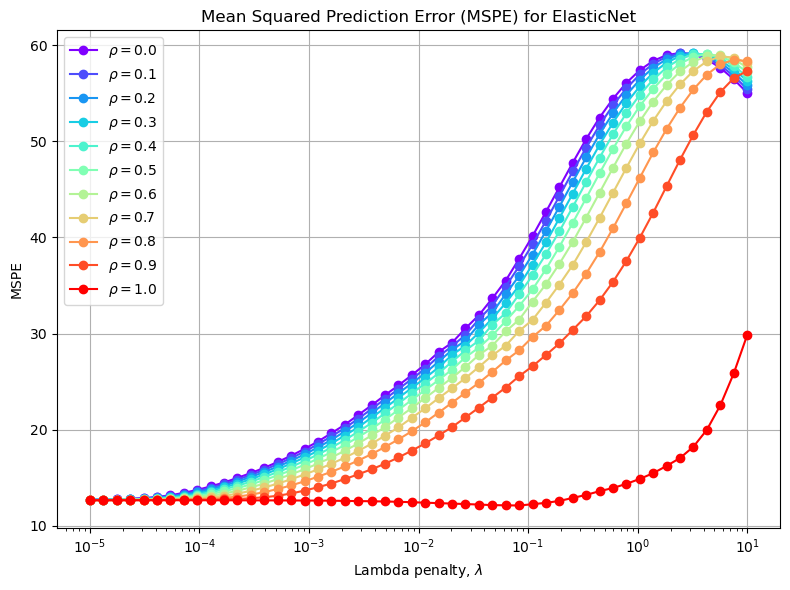

In [90]:
# Rainbow color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(final_mspe['y'].unique())))

plt.figure(figsize=(8, 6))
for idx, y_value in enumerate(final_mspe['y'].unique()):
    subset = final_mspe[final_mspe['y'] == y_value]
    plt.plot(subset['x'], subset['smape_val'], marker='o', label=r'$\rho={}$'.format(round(y_value, 1)), color=colors[idx])

plt.xlabel(r'Lambda penalty, $\lambda$')
plt.ylabel('MSPE')
plt.title('Mean Squared Prediction Error (MSPE) for ElasticNet')
plt.legend()
plt.xscale('log') 
plt.grid(True)
plt.tight_layout()

plt.show()

SMAPE baseline out of sample prediction: 24.023807691686883


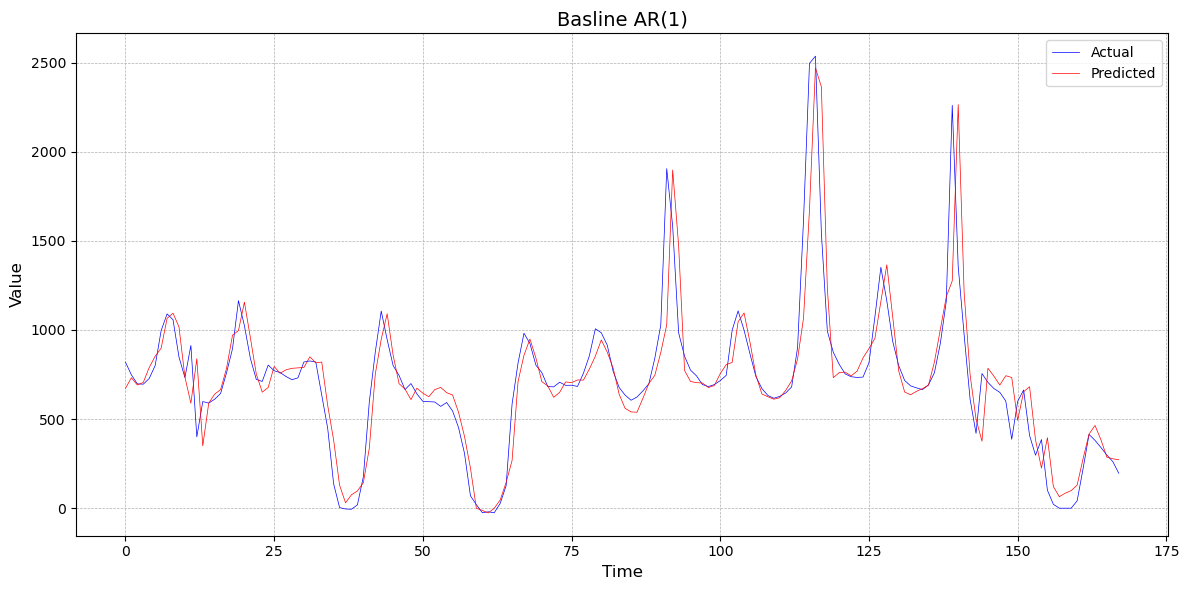

In [91]:

X_in_sample = data_train.drop(columns=["DK2_spot"])
y_in_sample = data_train["DK2_spot"]

model = ElasticNet(alpha=optimal_lambda, l1_ratio=optimal_rho, fit_intercept=False)
model.fit(X_in_sample, y_in_sample)

X_out_of_sample = data_test.drop(columns=["DK2_spot"])
y_out_of_sample = data_test["DK2_spot"]

y_pred = model.predict(X_out_of_sample)

y_test = data_test["DK2_spot"].to_numpy()

smape_elastic_net = smape(y_test, y_pred)

print(f'SMAPE baseline out of sample prediction: {smape_elastic_net}')

plot_actual_vs_predicted(y_test, y_pred, "Basline AR(1)")